<a href="https://colab.research.google.com/github/nguyenfan20/Traffic_SGU/blob/main/Vietnamese_Legal_Traffic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T·ªïng quan d·ª± √°n ü§ñ

Notebook n√†y tr√¨nh b√†y c√°ch t·∫°o m·ªôt chatbot b·∫±ng h·ªá th·ªëng RAG d·ª±a v√†o th∆∞ vi·ªán LangChain v√† LLMs

In [2]:
!pip uninstall -y fsspec datasets gcsfs
!pip install fsspec==2024.12.0 datasets==3.5.0 gcsfs==2024.12.0
!pip install -q torch transformers accelerate bitsandbytes \
  langchain sentence-transformers faiss-cpu openpyxl pacmap datasets \
  langchain-community ragatouille tqdm pymupdf python-docx pandas

Found existing installation: fsspec 2024.12.0
Uninstalling fsspec-2024.12.0:
  Successfully uninstalled fsspec-2024.12.0
Found existing installation: datasets 3.5.0
Uninstalling datasets-3.5.0:
  Successfully uninstalled datasets-3.5.0
Found existing installation: gcsfs 2024.12.0
Uninstalling gcsfs-2024.12.0:
  Successfully uninstalled gcsfs-2024.12.0
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached datasets-3.5.0-py3-none-any.whl.metadata (19 kB)
  Using cached gcsfs-2024.12.0-py2.py3-none-any.whl.metadata (1.6 kB)
Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
Using cached datasets-3.5.0-py3-none-any.whl (491 kB)
Using cached gcsfs-2024.12.0-py2.py3-none-any.whl (35 kB)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple

FILE_01 = '/content/luatgt2 (1).pdf'


VECTOR_DATABASE_PATH = '/content/vectordatabase'
os.makedirs('/content/vectordatabase', exist_ok=True)

# Chunking üî™

In [5]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm
from langchain.document_loaders import PyMuPDFLoader
from docx import Document as DocxDocument
import pandas as pd
import os

def load_pdf_file(file_path):
    """Loads a PDF file and returns its entire content using PyMuPDFLoader."""
    loader = PyMuPDFLoader(file_path)
    documents = loader.load()
    full_content = ""
    for doc in documents:
        full_content += doc.page_content + "\n"  # Add a newline to separate pages
    return full_content  # Return the entire content

def load_txt_file(file_path):
    """Loads a TXT file and returns its content as a string."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def load_docx_file(file_path):
    """Loads a DOCX file and returns its content as a string."""
    doc = DocxDocument(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

def load_csv_file(file_path):
    """Loads a CSV file and concatenates all rows as a single string."""
    df = pd.read_csv(file_path)
    return df.to_string(index=False)  # Converts the DataFrame to a string (without row indices)

def load_file(file_path):
    """Determines the file type and loads the file content."""
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.txt':
        return load_txt_file(file_path)
    elif ext in ['.doc', '.docx']:
        return load_docx_file(file_path)
    elif ext == '.pdf':
        return load_pdf_file(file_path)
    elif ext == '.csv':
        return load_csv_file(file_path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")

In [6]:
# List of document file paths (PDF, DOCX, TXT, CSV)
file_paths = [FILE_01] # Example file paths. It can be like: file_paths = [FILE_01, FILE_02,..]

RAW_KNOWLEDGE_BASE = []
for file_path in tqdm(file_paths):
    try:
        content = load_file(file_path)
        RAW_KNOWLEDGE_BASE.append(
            LangchainDocument(page_content=content, metadata={"source": file_path})
        )
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1/1 [00:01<00:00,  1.17s/it]


In [7]:
for doc in RAW_KNOWLEDGE_BASE:
    print(f"Source: {doc.metadata['source']}")
    print(f"Content snippet: {doc.page_content[:500]}...\n")

Source: /content/luatgt2 (1).pdf
Content snippet: CH√çNH PH·ª¶
--------
C·ªòNG H√íA X√É H·ªòI CH·ª¶NGHƒ®A VI·ªÜT NAM
ƒê·ªôc l·∫≠p - T·ª±do - H·∫°nh ph√∫c
---------------
S·ªë: 168/2024/Nƒê-CP
H√† N·ªôi, ng√†y 26 th√°ng 12 nƒÉm 2024
NGH·ªäƒê·ªäNH
QUY ƒê·ªäNH X·ª¨PH·∫†T VI PH·∫†M H√ÄNH CH√çNH V·ªÄTR·∫¨T T·ª∞, AN TO√ÄN GIAO
TH√îNG TRONG Lƒ®NH V·ª∞C GIAO TH√îNG ƒê∆Ø·ªúNG B·ªò; TR·ª™ƒêI·ªÇM, PH·ª§C H·ªíI
ƒêI·ªÇM GI·∫§Y PH√âP L√ÅI XE
CƒÉn c·ª©Lu·∫≠t T·ªïch·ª©c Ch√≠nh ph·ªßng√†y 19 th√°ng 6 nƒÉm 2015; Lu·∫≠t s·ª≠a ƒë·ªïi, b·ªïsung m·ªôt
s·ªëƒëi·ªÅu c·ªßa Lu·∫≠t T·ªïch·ª©c Ch√≠nh ph·ªßv√† Lu·∫≠t T·ªïch·ª©c ch√≠nh quy·ªÅn ƒë·ªãa ph∆∞∆°ng ng√†y 22
th√°ng 11 nƒÉm 2019;
CƒÉn c·ª©Lu·∫≠t X·ª≠l√Ω vi ph·∫°m h√†...



In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])
print(docs_processed[1])

page_content='Ch∆∞∆°ng I
NH·ªÆNG QUY ƒê·ªäNH CHUNG
ƒêi·ªÅu 1. Ph·∫°m vi ƒëi·ªÅu ch·ªânh
1. Ngh·ªãƒë·ªãnh n√†y quy ƒë·ªãnh v·ªÅ:
a) X·ª≠ph·∫°t vi ph·∫°m h√†nh ch√≠nh v·ªÅtr·∫≠t t·ª±, an to√†n giao th√¥ng trong lƒ©nh v·ª±c giao th√¥ng
ƒë∆∞·ªùng b·ªôbao g·ªìm: h√†nh vi vi ph·∫°m h√†nh ch√≠nh; h√¨nh th·ª©c, m·ª©c x·ª≠ph·∫°t, bi·ªán ph√°p kh·∫Øc
ph·ª•c h·∫≠u qu·∫£ƒë·ªëi v·ªõi t·ª´ng h√†nh vi vi ph·∫°m h√†nh ch√≠nh; th·∫©m quy·ªÅn l·∫≠p bi√™n b·∫£n, th·∫©m
quy·ªÅn x·ª≠ph·∫°t, m·ª©c ph·∫°t ti·ªÅn c·ª•th·ªÉtheo t·ª´ng ch·ª©c danh ƒë·ªëi v·ªõi h√†nh vi vi ph·∫°m h√†nh
ch√≠nh v·ªÅtr·∫≠t t·ª±, an to√†n giao th√¥ng trong lƒ©nh v·ª±c giao th√¥ng ƒë∆∞·ªùng b·ªô;
b) M·ª©c tr·ª´ƒëi·ªÉm gi·∫•y ph√©p l√°i xe ƒë·ªëi v·ªõi t·ª´ng h√†nh vi vi ph·∫°m h√†nh ch√≠nh; tr√¨nh t·ª±, th·ªß
t·ª•c, th·∫©m quy·ªÅn tr·ª´ƒëi·ªÉm, ph·ª•c h·ªìi ƒëi·ªÉm gi·∫•y ph√©p l√°i xe ƒë·ªÉqu·∫£n l√Ω vi·ªác ch·∫•p h√†nh ph√°p
lu·∫≠t v·ªÅtr·∫≠t t·ª±, an to√†n giao th√¥ng ƒë∆∞·ªùng b·ªôc·ªßa ng∆∞·ªùi l√°i xe.
2. C√°c h√†nh vi vi ph·∫°

# Embedding document üìÇ

In [9]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "/content/drive/MyDrive/models/vietnamese_embedding"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    258,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Vector Database üìÇ

In [10]:
import os
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)


<ipython-input-10-a460f51192b9>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


# L∆∞u Vector Database ƒë∆∞·ª£c x·ª≠ l√Ω v√†o c√°c th∆∞ m·ª•c

In [11]:
import faiss  # Make sure to import FAISS
import pickle

# Save the FAISS index to a file
faiss_file_path = os.path.join(VECTOR_DATABASE_PATH, 'faiss_index.bin')
faiss.write_index(KNOWLEDGE_VECTOR_DATABASE.index, faiss_file_path)
print(f"FAISS index saved to {faiss_file_path}")

# Save the document store to a pickle file
docstore_file_path = os.path.join(VECTOR_DATABASE_PATH, 'docstore.pkl')
with open(docstore_file_path, 'wb') as f:
    pickle.dump(KNOWLEDGE_VECTOR_DATABASE.docstore, f)
print(f"Document store saved to {docstore_file_path}")

# Save the index_to_docstore_id mapping
mapping_file_path = os.path.join(VECTOR_DATABASE_PATH, 'index_to_docstore_id.pkl')
with open(mapping_file_path, 'wb') as f:
    pickle.dump(KNOWLEDGE_VECTOR_DATABASE.index_to_docstore_id, f)
print(f"Index to document store ID mapping saved to {mapping_file_path}")

# Load the FAISS index from the file
loaded_index = faiss.read_index(faiss_file_path)

# Load the document store from the pickle file
with open(docstore_file_path, 'rb') as f:
    loaded_docstore = pickle.load(f)

# Load the index_to_docstore_id mapping
with open(mapping_file_path, 'rb') as f:
    index_to_docstore_id = pickle.load(f)

# Create the FAISS vector store using the loaded index and document store
loaded_vector_database = FAISS(
    index=loaded_index,
    docstore=loaded_docstore,
    index_to_docstore_id=index_to_docstore_id,
    embedding_function=embedding_model.embed_query
)
print("Vector database loaded successfully.")

FAISS index saved to /content/vectordatabase/faiss_index.bin
Document store saved to /content/vectordatabase/docstore.pkl
Index to document store ID mapping saved to /content/vectordatabase/index_to_docstore_id.pkl
Vector database loaded successfully.


# Chain v·ªõi th∆∞ m·ª•c ƒë√£ l∆∞u

In [12]:
# Embed a user query in the same space
user_query = "Quy ƒë·ªãnh v·ªÅ ƒë·ªô tu·ªïi l√°i xe m√¥ t√¥ hai b√°nh?"
query_vector = embedding_model.embed_query(user_query)

In [13]:
print(f"\nStarting retrieval for {user_query=}...")
# retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

retrieved_docs = loaded_vector_database.similarity_search(query=user_query, k=5)

print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Quy ƒë·ªãnh v·ªÅ ƒë·ªô tu·ªïi l√°i xe m√¥ t√¥ hai b√°nh?'...

==================================Top document==================================
Giao th√¥ng ƒë∆∞·ªùng b·ªônƒÉm 1968 c·∫•p (tr·ª´gi·∫•y ph√©p l√°i xe qu·ªëc t·∫ødo Vi·ªát Nam c·∫•p)
nh∆∞ng kh√¥ng mang theo gi·∫•y ph√©p l√°i xe qu·ªëc gia ph√π h·ª£p v·ªõi lo·∫°i xe ƒë∆∞·ª£c ph√©p ƒëi·ªÅu
khi·ªÉn;
c) S·ª≠d·ª•ng gi·∫•y ph√©p l√°i xe kh√¥ng h·ª£p l·ªá(gi·∫•y ph√©p l√°i xe c√≥ s·ªëph√¥i ghi ·ªüm·∫∑t sau
kh√¥ng tr√πng v·ªõi s·ªëph√¥i ƒë∆∞·ª£c c·∫•p m·ªõi nh·∫•t trong h·ªáth·ªëng th√¥ng tin qu·∫£n l√Ω gi·∫•y ph√©p l√°i
xe).
6. Ph·∫°t ti·ªÅn t·ª´4.000.000 ƒë·ªìng ƒë·∫øn 6.000.000 ƒë·ªìng ƒë·ªëi v·ªõi ng∆∞·ªùi t·ª´ƒë·ªß16 tu·ªïi ƒë·∫øn d∆∞·ªõi
18 tu·ªïi ƒëi·ªÅu khi·ªÉn xe √¥ t√¥, xe ch·ªüng∆∞·ªùi b·ªën b√°nh c√≥ g·∫Øn ƒë·ªông c∆°, xe ch·ªüh√†ng b·ªën b√°nh
c√≥ g·∫Øn ƒë·ªông c∆° v√† c√°c lo·∫°i xe t∆∞∆°ng t·ª±xe √¥ t√¥.
7. Ph·∫°t ti·ªÅn t·ª´6.000.000 ƒë·ªìng ƒë·∫øn 8.000.000 ƒë·ªìng ƒë·ªëi v·ªõi ng∆

# ƒê∆∞a LLM ƒë·ªÉ t·∫°o sinh c√¢u tr·∫£ l·ªùi v·ªõi d·ªØ li·ªáu ƒë∆∞·ª£c chain

In [14]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

# C·∫•u h√¨nh bitsandbytes ƒë·ªÉ t·∫£i m√¥ h√¨nh ·ªü ƒë·ªãnh d·∫°ng 4-bit ti·∫øt ki·ªám RAM
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,  # ƒê·ªïi sang float16 n·∫øu bfloat16 kh√¥ng ƒë∆∞·ª£c h·ªó tr·ª£
)

# Load m√¥ h√¨nh v·ªõi c·∫•u h√¨nh nh·∫π, t·ª± ƒë·ªông ph√¢n b·ªï thi·∫øt b·ªã (GPU/CPU)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

# T·∫°o pipeline ƒë·ªÉ d√πng m√¥ h√¨nh nh∆∞ 1 RAG Reader
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


In [15]:
!pip -q install langdetect

     ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 981.5/981.5 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [16]:
from langdetect import detect

prompt_in_chat_format_en = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

# Prompt template for Vietnamese
prompt_in_chat_format_vi = [
    {
        "role": "system",
        "content": """S·ª≠ d·ª•ng th√¥ng tin trong ng·ªØ c·∫£nh, h√£y ƒë∆∞a ra c√¢u tr·∫£ l·ªùi ƒë·∫ßy ƒë·ªß cho c√¢u h·ªèi.
Ch·ªâ tr·∫£ l·ªùi c√¢u h·ªèi ƒë∆∞·ª£c h·ªèi, c√¢u tr·∫£ l·ªùi c·∫ßn ng·∫Øn g·ªçn v√† ph√π h·ª£p v·ªõi c√¢u h·ªèi.
Cung c·∫•p s·ªë c·ªßa t√†i li·ªáu ngu·ªìn khi ph√π h·ª£p.
N·∫øu c√¢u tr·∫£ l·ªùi kh√¥ng th·ªÉ suy ra t·ª´ ng·ªØ c·∫£nh, kh√¥ng ƒë∆∞a ra c√¢u tr·∫£ l·ªùi.""",
    },
    {
        "role": "user",
        "content": """Ng·ªØ c·∫£nh:
{context}
---
B√¢y gi·ªù ƒë√¢y l√† c√¢u h·ªèi m√† b·∫°n c·∫ßn tr·∫£ l·ªùi.

C√¢u h·ªèi: {question}""",
    },
]

def detect_language(query):
    return detect(query)

def create_prompt(question):

    language = detect_language(question)

    if language == 'vi':
        RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
            prompt_in_chat_format_vi, tokenize=False, add_generation_prompt=True
        )
    else:
        RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
            prompt_in_chat_format_en, tokenize=False, add_generation_prompt=True
        )

    return RAG_PROMPT_TEMPLATE

#test prompt if the question is Vietnamese

test_prompt = create_prompt("H√† N·ªôi l√† th·ªß ƒë√¥ c·ªßa n∆∞·ªõc n√†o?")
print(test_prompt)

<|system|>
S·ª≠ d·ª•ng th√¥ng tin trong ng·ªØ c·∫£nh, h√£y ƒë∆∞a ra c√¢u tr·∫£ l·ªùi ƒë·∫ßy ƒë·ªß cho c√¢u h·ªèi.
Ch·ªâ tr·∫£ l·ªùi c√¢u h·ªèi ƒë∆∞·ª£c h·ªèi, c√¢u tr·∫£ l·ªùi c·∫ßn ng·∫Øn g·ªçn v√† ph√π h·ª£p v·ªõi c√¢u h·ªèi.
Cung c·∫•p s·ªë c·ªßa t√†i li·ªáu ngu·ªìn khi ph√π h·ª£p.
N·∫øu c√¢u tr·∫£ l·ªùi kh√¥ng th·ªÉ suy ra t·ª´ ng·ªØ c·∫£nh, kh√¥ng ƒë∆∞a ra c√¢u tr·∫£ l·ªùi.</s>
<|user|>
Ng·ªØ c·∫£nh:
{context}
---
B√¢y gi·ªù ƒë√¢y l√† c√¢u h·ªèi m√† b·∫°n c·∫ßn tr·∫£ l·ªùi.

C√¢u h·ªèi: {question}</s>
<|assistant|>



In [17]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

user_query="Quy ƒë·ªãnh v·ªÅ ƒë·ªô tu·ªïi l√°i xe m√¥ t√¥ 2 b√°nh?"

rag_prompt = create_prompt(user_query)
final_prompt = rag_prompt.format(
    question=user_query, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

C√¢u tr·∫£ l·ªùi: Ng∆∞·ªùi t·ª´ 16 tu·ªïi ƒë·∫øn d∆∞·ªõi 18 tu·ªïi ƒë∆∞·ª£c ph√©p l√°i xe m√¥ t√¥ hai b√°nh c√≥ dung t√≠ch xi-lanh tr√™n 50 cm3 ho·∫∑c c√≥ c√¥ng su·∫•t ƒë·ªông c∆° ƒëi·ªán t·ª´ 04 kW tr·ªü l√™n, nh∆∞ng ph·∫£i mang theo gi·∫•y ph√©p l√°i xe nh∆∞ng kh√¥ng ph√π h·ª£p v·ªõi lo·∫°i xe ƒëang ƒëi·ªÅu khi·ªÉn, v√† ph·∫£i b·ªã ph·∫°t ti·ªÅn t·ª´ 4.000.000 ƒë·ªìng ƒë·∫øn 6.000.000 ƒë·ªìng. Ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe m√¥ t√¥ hai b√°nh c≈©ng ph·∫£i ki·ªÉm ƒë·ªãnh an to√†n k·ªπthu·∫≠t v√† b·∫£o v·ªá m√¥i tr∆∞·ªùng, v√† ph·∫£i mang theo ch·ª©ng nh·∫≠n b·∫£o hi·ªÉm b·∫Øt bu·ªôc tr√°ch nhi·ªám d√¢n s·ª±c·ªßa ch·ªßxe c∆° gi·ªõi c√≤n hi·ªáu l·ª±c.


In [18]:
from transformers import pipeline, Pipeline

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:

    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    if not relevant_docs:
        raise ValueError("No relevant documents retrieved.")

    # Gi·ªØ b·∫£n g·ªëc ƒë·ªÉ return
    retrieved_docs = relevant_docs[:num_docs_final]  # gi·ªØ l·∫°i LangchainDocument g·ªëc

    # L·∫•y n·ªôi dung text ƒë·ªÉ ƒë∆∞a v√†o prompt
    docs_text = [doc.page_content for doc in retrieved_docs]

    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n{doc}" for i, doc in enumerate(docs_text)]
    )

    RAG_PROMPT_TEMPLATE = create_prompt(question)
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, retrieved_docs

In [19]:
question = "Nguy√™n t·∫Øc tr·ª´ ƒëi·ªÉm gi·∫•y ph√©p l√°i xe v·ªõi gi·∫•y ph√©p l√°i xe kh√¥ng gi·ªõi h·∫°n?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, loaded_vector_database)

=> Retrieving documents...
=> Generating answer...


In [20]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
C√¢u tr·∫£ l·ªùi: N·∫øu ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe m√¥ t√¥, xe t∆∞∆°ng t·ª±xe m√¥ t√¥ ho·∫∑c ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe √¥ t√¥, xe t∆∞∆°ng t·ª±xe √¥ t√¥, xe ch·ªü ng∆∞·ªùi b·ªën b√°nh c√≥ g·∫Øn ƒë·ªông c∆°, xe ch·ªüh√†ng b·ªën b√°nh c√≥ g·∫Øn ƒë·ªông c∆° ƒë√≥ng gi·∫•y ph√©p l√°i xe kh√¥ng gi·ªõi h·∫°n (kh√¥ng c√≥ th·ªùi h·∫°n), th√¨ khi ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe b·ªã ph·∫°t h√†nh vi vi ph·∫°m quy ƒë·ªãnh, n·∫øu ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe ƒë√≥ng gi·∫•y ph√©p l√°i xe kh√¥ng gi·ªõi h·∫°n th√¨ ng∆∞·ªùi c√≥ th·∫©m quy·ªÅn x·ª≠ph·∫°t tr·ª´ ƒëi·ªÉm gi·∫•y ph√©p l√°i xe nh∆∞ sau:

- Tr∆∞·ªùng h·ª£p s·ªëƒëi·ªÉm c√≤n l·∫°i c·ªßa gi·∫•y ph√©p l√°i xe √≠t h∆°n s·ªëƒëi·ªÉm b·ªã tr·ª´th√¨ √°p d·ª•ng tr·ª´ h·∫øt s·ªëƒëi·ªÉm c√≤n l·∫°i c·ªßa gi·∫•y ph√©p l√°i xe ƒë√≥.
- Ng∆∞·ªùi c√≥ th·∫©m quy·ªÅn x·ª≠ph·∫°t th·ª±c hi·ªán tr·ª´ ƒëi·ªÉm gi·∫•y ph√©p l√°i xe khi ng∆∞·ªùi ƒëi·ªÅu khi·ªÉn xe m√¥ t√¥, xe t∆∞∆°ng t·ª±xe m√¥ t√¥ 

In [21]:
!pip -q install gradio

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 54.1/54.1 MB 18.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 323.1/323.1 kB 28.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 95.2/95.2 kB 9.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11.6/11.6 MB 117.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 62.5/62.5 kB 5.7 MB/s eta 0:00:00


In [22]:
import gradio as gr
def rag_interface(question):
    answer, relevant_docs = answer_with_rag(
        question, READER_LLM, loaded_vector_database)
    docs_text = "\n\n".join([doc.page_content for doc in relevant_docs])

    return answer, docs_text

gr.Interface(
    fn=rag_interface,
    inputs=gr.Textbox(lines=2, label="Nh·∫≠p c√¢u h·ªèi:"),
    outputs=[
        gr.Textbox(label="C√¢u tr·∫£ l·ªùi t·ª´ h·ªá th·ªëng RAG"),
        gr.Textbox(label="T√†i li·ªáu li√™n quan ƒë∆∞·ª£c truy xu·∫•t")
    ],
    title="üí¨ H·ªá th·ªëng h·ªèi ƒë√°p RAG",
    description="Nh·∫≠p m·ªôt c√¢u h·ªèi v√† nh·∫≠n c√¢u tr·∫£ l·ªùi t·ª´ h·ªá th·ªëng RAG k·∫øt h·ª£p t√¨m ki·∫øm t√†i li·ªáu."
).launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://50323d36c3e7f5c097.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [24]:
EVAL_CSV_FILE = "test.csv"  # ƒê∆∞·ªùng d·∫´n ƒë·∫øn file CSV ch·ª©a b·ªô ƒë√°nh gi√°

def load_evaluation_data(csv_file_path: str) -> pd.DataFrame:
    """Loads the evaluation data from a CSV file."""
    return pd.read_csv(csv_file_path, encoding='utf-8')

def evaluate_answer(
    question: str,
    ground_truth: str,
    rag_answer: str,
    relevant_docs: List[LangchainDocument],
) -> dict:
    """
    Evaluates the RAG answer based on several criteria.
    This is where you implement your detailed evaluation logic.
    """

    evaluation = {}

    # 1. Correctness (T√≠nh ƒë√∫ng ƒë·∫Øn)
    correctness_keywords = 0
    ground_truth_keywords = ground_truth.lower().split()
    for keyword in ground_truth_keywords:
        if keyword in rag_answer.lower():
            correctness_keywords += 1
    evaluation["correctness"] = min(5, correctness_keywords)  # Scale to 1-5

    # 2. Relevance (T√≠nh li√™n quan)
    # ƒê·∫øm s·ªë document ƒë∆∞·ª£c retrieved c√≥ ch·ª©a c√°c keyword t·ª´ ground truth
    relevant_doc_count = 0
    for doc in relevant_docs:
        if any(keyword in doc.page_content.lower() for keyword in ground_truth_keywords):
            relevant_doc_count += 1
    evaluation["relevance"] = min(5, relevant_doc_count)

    # 3. Completeness (T√≠nh ƒë·∫ßy ƒë·ªß)
    completeness_score = len(rag_answer) / len(ground_truth) if len(ground_truth) > 0 else 1
    evaluation["completeness"] = min(5, int(completeness_score * 5))

    # 4. Conciseness (T√≠nh tr√¥i ch·∫£y)
    evaluation["conciseness"] = 5 if len(rag_answer) <= len(ground_truth) * 1.2 else 3

    return evaluation

def main_evaluation(
    llm: Pipeline,
    knowledge_index: FAISS,
    eval_csv_path: str,
    num_retrieved_docs: int = 10,
    num_docs_final: int = 3,
):
    """
    Main evaluation loop.
    """

    eval_data = load_evaluation_data(eval_csv_path)
    eval_results = []

    for index, row in tqdm(eval_data.iterrows(), total=len(eval_data)):
        question = row["question"]
        ground_truth = row["ground_truth_answer"]

        try:
            rag_answer, retrieved_docs = answer_with_rag(
                question, llm, knowledge_index, num_retrieved_docs, num_docs_final
            )
        except ValueError as e:
            print(f"Error processing question: {question} - {e}")
            eval_results.append(
                {"question": question, "ground_truth": ground_truth, "error": str(e)}
            )
            continue

        evaluation = evaluate_answer(question, ground_truth, rag_answer, retrieved_docs)
        evaluation["question"] = question
        evaluation["ground_truth"] = ground_truth
        evaluation["rag_answer"] = rag_answer

        eval_results.append(evaluation)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(eval_results)
    results_df.to_csv("rag_evaluation_results.csv", encoding="utf-8", index=False)
    print("Evaluation completed. Results saved to 'rag_evaluation_results.csv'")

# Ch·∫°y ƒë√°nh gi√°
if __name__ == "__main__":
    main_evaluation(
        READER_LLM,
        loaded_vector_database,
        EVAL_CSV_FILE,
        num_retrieved_docs=20,
        num_docs_final=5,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

=> Retrieving documents...
=> Generating answer...


 10%|‚ñà         | 1/10 [00:54<08:08, 54.24s/it]

=> Retrieving documents...
=> Generating answer...


 20%|‚ñà‚ñà        | 2/10 [01:16<04:42, 35.26s/it]

=> Retrieving documents...
=> Generating answer...


 30%|‚ñà‚ñà‚ñà       | 3/10 [02:11<05:09, 44.20s/it]

=> Retrieving documents...
=> Generating answer...


 40%|‚ñà‚ñà‚ñà‚ñà      | 4/10 [02:30<03:27, 34.60s/it]

=> Retrieving documents...
=> Generating answer...


 50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 5/10 [03:33<03:43, 44.72s/it]

=> Retrieving documents...
=> Generating answer...


 60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 6/10 [03:54<02:27, 36.76s/it]

=> Retrieving documents...
=> Generating answer...


 70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 7/10 [04:47<02:06, 42.01s/it]

=> Retrieving documents...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=> Generating answer...


 80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 8/10 [05:16<01:15, 37.66s/it]

=> Retrieving documents...
=> Generating answer...


 90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 9/10 [06:10<00:42, 42.95s/it]

=> Retrieving documents...
=> Generating answer...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [06:33<00:00, 39.39s/it]

Evaluation completed. Results saved to 'rag_evaluation_results.csv'


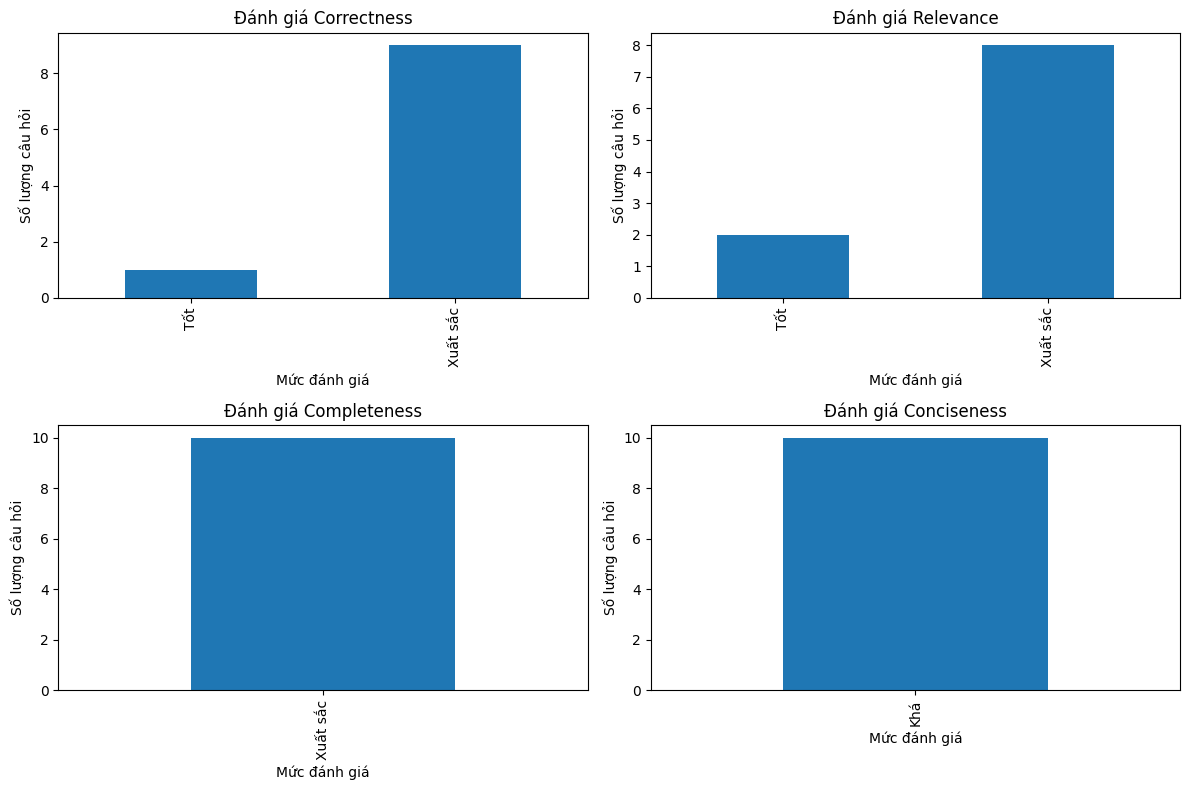

Th·ªëng k√™ ƒë√°nh gi√° Correctness:
 danh_gia_correctness
Xu·∫•t s·∫Øc    9
T·ªët         1
Name: count, dtype: int64

Th·ªëng k√™ ƒë√°nh gi√° Relevance:
 danh_gia_relevance
Xu·∫•t s·∫Øc    8
T·ªët         2
Name: count, dtype: int64

Th·ªëng k√™ ƒë√°nh gi√° Completeness:
 danh_gia_completeness
Xu·∫•t s·∫Øc    10
Name: count, dtype: int64

Th·ªëng k√™ ƒë√°nh gi√° Conciseness:
 danh_gia_conciseness
Kh√°    10
Name: count, dtype: int64


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. ƒê·ªçc d·ªØ li·ªáu t·ª´ file CSV
df = pd.read_csv("rag_evaluation_results.csv")

# 2. ƒê·ªãnh nghƒ©a thang ƒëi·ªÉm (v√≠ d·ª•)
thang_diem = {
    5: "Xu·∫•t s·∫Øc",
    4: "T·ªët",
    3: "Kh√°",
    2: "Trung b√¨nh",
    1: "K√©m"
}

# 3. √Ånh x·∫° ƒëi·ªÉm s·ªë v√†o thang ƒëi·ªÉm
def danh_gia_theo_thang_diem(diem):
    for muc_diem, danh_gia in thang_diem.items():
        if diem >= muc_diem:
            return danh_gia
    return "K√©m"  # M·∫∑c ƒë·ªãnh n·∫øu kh√¥ng c√≥ m·ª©c n√†o ph√π h·ª£p

df["danh_gia_correctness"] = df["correctness"].apply(danh_gia_theo_thang_diem)
df["danh_gia_relevance"] = df["relevance"].apply(danh_gia_theo_thang_diem)  # ƒê√É S·ª¨A L·ªñI ·ªû ƒê√ÇY
df["danh_gia_completeness"] = df["completeness"].apply(danh_gia_theo_thang_diem)
df["danh_gia_conciseness"] = df["conciseness"].apply(danh_gia_theo_thang_diem)

# 4. Th·ªëng k√™ s·ªë l∆∞·ª£ng ƒë√°nh gi√° cho t·ª´ng m·ª©c
thong_ke_correctness = df["danh_gia_correctness"].value_counts()
thong_ke_relevance = df["danh_gia_relevance"].value_counts()
thong_ke_completeness = df["danh_gia_completeness"].value_counts()
thong_ke_conciseness = df["danh_gia_conciseness"].value_counts()

# 5. Tr·ª±c quan h√≥a b·∫±ng bi·ªÉu ƒë·ªì c·ªôt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
thong_ke_correctness.sort_index().plot(kind="bar")
plt.title("ƒê√°nh gi√° Correctness")
plt.xlabel("M·ª©c ƒë√°nh gi√°")
plt.ylabel("S·ªë l∆∞·ª£ng c√¢u h·ªèi")

plt.subplot(2, 2, 2)
thong_ke_relevance.sort_index().plot(kind="bar")
plt.title("ƒê√°nh gi√° Relevance")
plt.xlabel("M·ª©c ƒë√°nh gi√°")
plt.ylabel("S·ªë l∆∞·ª£ng c√¢u h·ªèi")

plt.subplot(2, 2, 3)
thong_ke_completeness.sort_index().plot(kind="bar")
plt.title("ƒê√°nh gi√° Completeness")
plt.xlabel("M·ª©c ƒë√°nh gi√°")
plt.ylabel("S·ªë l∆∞·ª£ng c√¢u h·ªèi")

plt.subplot(2, 2, 4)
thong_ke_conciseness.sort_index().plot(kind="bar")
plt.title("ƒê√°nh gi√° Conciseness")
plt.xlabel("M·ª©c ƒë√°nh gi√°")
plt.ylabel("S·ªë l∆∞·ª£ng c√¢u h·ªèi")

plt.tight_layout()  # ƒê·ªÉ c√°c bi·ªÉu ƒë·ªì kh√¥ng b·ªã ch·ªìng ch√©o
plt.show()

# 6. In ra th·ªëng k√™ d·∫°ng b·∫£ng (t√πy ch·ªçn)
print("Th·ªëng k√™ ƒë√°nh gi√° Correctness:\n", thong_ke_correctness)
print("\nTh·ªëng k√™ ƒë√°nh gi√° Relevance:\n", thong_ke_relevance)
print("\nTh·ªëng k√™ ƒë√°nh gi√° Completeness:\n", thong_ke_completeness)
print("\nTh·ªëng k√™ ƒë√°nh gi√° Conciseness:\n", thong_ke_conciseness)

In [ ]:
import os
os.kill(os.getpid(), 9)
